In [ ]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from torchvision.models import Inception_V3_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

In [ ]:
train_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)

In [ ]:
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)



In [ ]:
from sklearn.model_selection import train_test_split


train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (18678, 2)
Val: (4003, 2)
Test: (4003, 2)


In [ ]:
import os
import pydicom
import numpy as np
import random

TRAIN_IMG_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
class RSNADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]

        path = os.path.join(self.img_dir, pid + ".dcm")
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array

        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = np.stack([img]*3, axis=-1).astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)


In [ ]:
BATCH_SIZE = 8
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),

    transforms.ToTensor(),
])

train_loader = DataLoader(
    RSNADataset(train_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    RSNADataset(val_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

test_loader = DataLoader(
    RSNADataset(test_df, TRAIN_IMG_DIR, transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)


In [ ]:
train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [ ]:
class InceptionV3CustomModel(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5):
        super().__init__()
        # Load pretrained InceptionV3 with aux_logits enabled (required for weights)
        # then disable auxiliary logits for the forward pass.
        if pretrained:
            inception = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
            inception.aux_logits = False
        else:
            inception = models.inception_v3(weights=None, aux_logits=False)

        # Build the feature extractor using layers up to Mixed_7c.
        self.features = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
        )

        # Global max pooling: (B, 2048, 10, 10) → (B, 2048, 1, 1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)

        # Fully connected layer: reduces features from 2048 to 128.
        self.fc = nn.Linear(2048, 128)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # Extract features from the input.
        x = self.features(x)
        # Apply global max pooling.
        x = self.global_max_pool(x)
        # Flatten the tensor: (B, 2048, 1, 1) → (B, 2048)
        x = torch.flatten(x, 1)
        # Fully connected layer and dropout.
        x = self.fc(x)
        x = self.dropout(x)
        return x

In [ ]:
class ConvDropConv(nn.Module):
    """
    A helper module that performs:
    1x1 convolution → dropout → convolution (with specified kernel parameters).
    """
    def __init__(self, in_channels, hidden_channels, out_channels, kernel_size, stride, padding, dropout_rate=0.5):
        super(ConvDropConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=1, stride=1, padding=0)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        return x

class PoolConv(nn.Module):
    """
    A helper module for average pooling followed by a 1x1 convolution.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(PoolConv, self).__init__()
        self.pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

class InceptionBlock(nn.Module):
    """
    A generic Inception-style downsampling block with four branches:
      - Branch 1: 1x1 conv with stride 2.
      - Branch 2: 1x1 conv → dropout → convolution.
      - Branch 3: 1x1 conv → dropout → convolution.
      - Branch 4: Average pooling → 1x1 conv.
    The branch outputs are concatenated along the channel dimension.
    """
    def __init__(self, in_channels,
                 branch1_out,
                 branch2_hidden, branch2_out, branch2_kernel, branch2_padding,
                 branch3_hidden, branch3_out, branch3_kernel, branch3_padding,
                 branch4_out, dropout_rate=0.5):
        super(InceptionBlock, self).__init__()
        # Branch 1: 1x1 conv with stride 2.
        self.branch1 = nn.Conv2d(in_channels, branch1_out, kernel_size=1, stride=2, padding=0)
        # Branch 2: 1x1 conv → dropout → conv with specified kernel parameters.
        self.branch2 = ConvDropConv(in_channels, branch2_hidden, branch2_out,
                                    kernel_size=branch2_kernel, stride=2, padding=branch2_padding,
                                    dropout_rate=dropout_rate)
        # Branch 3: 1x1 conv → dropout → conv with specified kernel parameters.
        self.branch3 = ConvDropConv(in_channels, branch3_hidden, branch3_out,
                                    kernel_size=branch3_kernel, stride=2, padding=branch3_padding,
                                    dropout_rate=dropout_rate)
        # Branch 4: Average pooling → 1x1 conv.
        self.branch4 = PoolConv(in_channels, branch4_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        return torch.cat([b1, b2, b3, b4], dim=1)

class CustomInceptionModuleDownsample(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CustomInceptionModuleDownsample, self).__init__()
        # Block 1: Downsample from 384x384 → 192x192, output channels = 128.
        # Branch outputs: 32, 32, 16, and 48 channels respectively.
        self.block1 = InceptionBlock(in_channels=3,
                                     branch1_out=32,
                                     branch2_hidden=32, branch2_out=32, branch2_kernel=3, branch2_padding=1,
                                     branch3_hidden=32, branch3_out=16, branch3_kernel=5, branch3_padding=2,
                                     branch4_out=48,
                                     dropout_rate=dropout_rate)
        # Block 2: Downsample from 192x192 → 96x96, output channels = 64.
        # Branch outputs: 16, 16, 8, and 24 channels respectively.
        self.block2 = InceptionBlock(in_channels=128,
                                     branch1_out=16,
                                     branch2_hidden=16, branch2_out=16, branch2_kernel=3, branch2_padding=1,
                                     branch3_hidden=16, branch3_out=8, branch3_kernel=5, branch3_padding=2,
                                     branch4_out=24,
                                     dropout_rate=dropout_rate)
        # Block 3: Downsample from 96x96 → 48x48, output channels = 32.
        # Branch outputs: 8, 8, 4, and 12 channels respectively.
        self.block3 = InceptionBlock(in_channels=64,
                                     branch1_out=8,
                                     branch2_hidden=8, branch2_out=8, branch2_kernel=3, branch2_padding=1,
                                     branch3_hidden=8, branch3_out=4, branch3_kernel=5, branch3_padding=2,
                                     branch4_out=12,
                                     dropout_rate=dropout_rate)

    def forward(self, x):
        # Assume input x shape is (B, 3, 384, 384)
        out1 = self.block1(x)   # → (B, 128, 192, 192)
        out2 = self.block2(out1)  # → (B, 64, 96, 96)
        out3 = self.block3(out2)  # → (B, 32, 48, 48)
        return out3

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=32, patch_size=8, embed_dim=16):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.conv = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """
        Input: (batch, 32, 48, 48)
        Output: (batch, num_patches, embed_dim), where num_patches = 48//patch_size * 48//patch_size
        """
        x = self.conv(x)  # (batch, embed_dim, num_patches_h, num_patches_w)
        x = x.flatten(2)  # (batch, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch, num_patches, embed_dim)
        return x

class CustomTransformerLayer(nn.Module):
    def __init__(self, embed_dim=16, num_heads=4, dropout_rate=0.1):
        super(CustomTransformerLayer, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.fc1 = nn.Linear(embed_dim, 32)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, embed_dim)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Skip connection 1 (input to add)
        x_norm1 = self.norm1(x)
        attn_output, _ = self.mha(x_norm1, x_norm1, x_norm1)
        x = x + attn_output  # Add skip connection

        # Skip connection 2 (add to add before output)
        x_norm2 = self.norm2(x)
        fc_output = self.fc1(x_norm2)
        fc_output = F.relu(fc_output)
        fc_output = self.dropout1(fc_output)
        fc_output = self.fc2(fc_output)
        fc_output = self.dropout2(fc_output)

        output = x + fc_output  # Add skip connection
        return output

class GlobalAvgPoolingModel(nn.Module):
    def __init__(self, in_channels=32, dropout_rate=0.5):
        super(GlobalAvgPoolingModel, self).__init__()
        # Global average pooling along the last dimension.
        # Input is assumed to have shape (batch, in_channels, L) and this layer
        # outputs shape (batch, in_channels, 1)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # Map pooled features to the desired 16-dimensional vector.
        self.fc0 = nn.Linear(in_channels, 16)

        # Then follow the specified pipeline:
        # 16 -> dropout -> dense (16 to 256) -> dropout -> dense (256 to 128) -> dropout
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(16, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x shape: (batch, in_channels, L)
        x = self.global_avg_pool(x)  # Shape: (batch, in_channels, 1)
        x = x.squeeze(-1)            # Shape: (batch, in_channels)
        x = self.fc0(x)              # Map to (batch, 16)
        x = self.dropout1(x)
        x = self.fc1(x)              # Shape: (batch, 256)
        x = self.dropout2(x)
        x = self.fc2(x)              # Shape: (batch, 128)
        x = self.dropout3(x)
        return x

In [ ]:
class LocalBranch(nn.Module):
    def __init__(self, dropout_rate=0.5, num_transformer_layers=2):
        super(LocalBranch, self).__init__()

        # Step 1: Custom Inception Module Downsample
        self.inception_downsample = CustomInceptionModuleDownsample(dropout_rate=dropout_rate)

        # Step 2: Patch Embedding
        self.patch_embedding = PatchEmbedding(in_channels=32, patch_size=8, embed_dim=16)

        # Step 3: Transformer Layers
        self.transformer_layers = nn.Sequential(
            *[CustomTransformerLayer(embed_dim=16, num_heads=4, dropout_rate=dropout_rate)
              for _ in range(num_transformer_layers)]
        )

        # Additional normalization layer after the last transformer layer.
        # It normalizes over the embedding dimension of size 16.
        self.final_norm = nn.LayerNorm(16)

        # Step 4: Global Average Pooling Model
        self.global_avg_pooling = GlobalAvgPoolingModel(in_channels=16, dropout_rate=dropout_rate)

    def forward(self, x):
        # Step 1: Inception Downsampling
        x = self.inception_downsample(x)  # Output shape: (batch, 32, 48, 48)

        # Step 2: Patch Embedding
        x = self.patch_embedding(x)  # Output shape: (batch, num_patches, 16)

        # Step 3: Transformer Layers
        x = self.transformer_layers(x)  # Output shape remains (batch, num_patches, 16)

        # Apply normalization before global pooling
        x = self.final_norm(x)  # (B, num_patches, 16)

        # Step 4: Global Average Pooling
        x = x.permute(0, 2, 1)  # Convert to (batch, 16, num_patches) for pooling
        x = self.global_avg_pooling(x)  # Output shape: (batch, 128)

        return x

In [ ]:
class InceptionTransformer(nn.Module):
    def __init__(self, dropout_rate=0.5, num_transformer_layers=8, pretrained=True):
        super(InceptionTransformer, self).__init__()
        self.global_branch = InceptionV3CustomModel(
            pretrained=pretrained, dropout_rate=dropout_rate
        )
        self.local_branch = LocalBranch(
            dropout_rate=dropout_rate,
            num_transformer_layers=num_transformer_layers
        )

        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        global_feat = self.global_branch(x)
        local_feat = self.local_branch(x)

        x = torch.cat([global_feat, local_feat], dim=1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)   # (B,1)
        return x


In [ ]:
model = InceptionTransformer(
    dropout_rate=0.5,
    num_transformer_layers=8,
    pretrained=True
)
model.to(device)
summary(model, (1, 3, 384, 384))


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 194MB/s] 


Layer (type:depth-idx)                             Output Shape              Param #
InceptionTransformer                               [1, 1]                    --
├─InceptionV3CustomModel: 1-1                      [1, 128]                  --
│    └─Sequential: 2-1                             [1, 2048, 10, 10]         --
│    │    └─BasicConv2d: 3-1                       [1, 32, 191, 191]         928
│    │    └─BasicConv2d: 3-2                       [1, 32, 189, 189]         9,280
│    │    └─BasicConv2d: 3-3                       [1, 64, 189, 189]         18,560
│    │    └─MaxPool2d: 3-4                         [1, 64, 94, 94]           --
│    │    └─BasicConv2d: 3-5                       [1, 80, 94, 94]           5,280
│    │    └─BasicConv2d: 3-6                       [1, 192, 92, 92]          138,624
│    │    └─MaxPool2d: 3-7                         [1, 192, 45, 45]          --
│    │    └─InceptionA: 3-8                        [1, 256, 45, 45]          255,904
│    │    └─In

In [ ]:
def custom_metrics(y_logits, y_true, loss, threshold=0.5):
    """
    Binary classification metrics using single-logit output.
    """

    # Ensure shapes
    if y_logits.dim() == 2:
        y_logits = y_logits.squeeze(1)

    # Probabilities
    y_probs = torch.sigmoid(y_logits)

    # Predictions
    y_pred = (y_probs >= threshold).long()

    # Move to CPU numpy
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    y_probs_np = y_probs.cpu().numpy()

    # Core metrics
    accuracy = accuracy_score(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np, zero_division=0)
    recall = recall_score(y_true_np, y_pred_np, zero_division=0)
    f1 = f1_score(y_true_np, y_pred_np, zero_division=0)
    mcc = matthews_corrcoef(y_true_np, y_pred_np)

    # Confusion matrix
    cm = confusion_matrix(y_true_np, y_pred_np)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp + 1e-8)
    sensitivity = tp / (tp + fn + 1e-8)

    # AUC (binary)
    try:
        auc = roc_auc_score(y_true_np, y_probs_np)
    except ValueError:
        auc = 0.0

    return {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc,
    }


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)


In [ ]:
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0

In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for data, targets in tqdm(train_loader, desc=f"Training Epoch [{epoch+1}/{num_epochs}]"):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)              # (B,1)

        targets = targets.float().unsqueeze(1)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().squeeze(1).numpy())
        all_targets.extend(targets.detach().cpu().squeeze(1).numpy())

    average_loss = total_loss / len(train_loader)

    train_metrics = custom_metrics(
        torch.tensor(all_predictions),
        torch.tensor(all_targets),
        average_loss
    )

    for k in metric_names:
        train_metrics_history[k].append(train_metrics[k])

    # ---------------- VALIDATION ----------------
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc="Validating"):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)

            targets = targets.float().unsqueeze(1)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            all_predictions.extend(outputs.detach().cpu().squeeze(1).numpy())
            all_targets.extend(targets.detach().cpu().squeeze(1).numpy())

    average_loss = total_loss / len(val_loader)

    val_metrics = custom_metrics(
        torch.tensor(all_predictions),
        torch.tensor(all_targets),
        average_loss
    )

    for k in metric_names:
        val_metrics_history[k].append(val_metrics[k])


Validating: 100%|██████████| 501/501 [00:43<00:00, 11.55it/s]


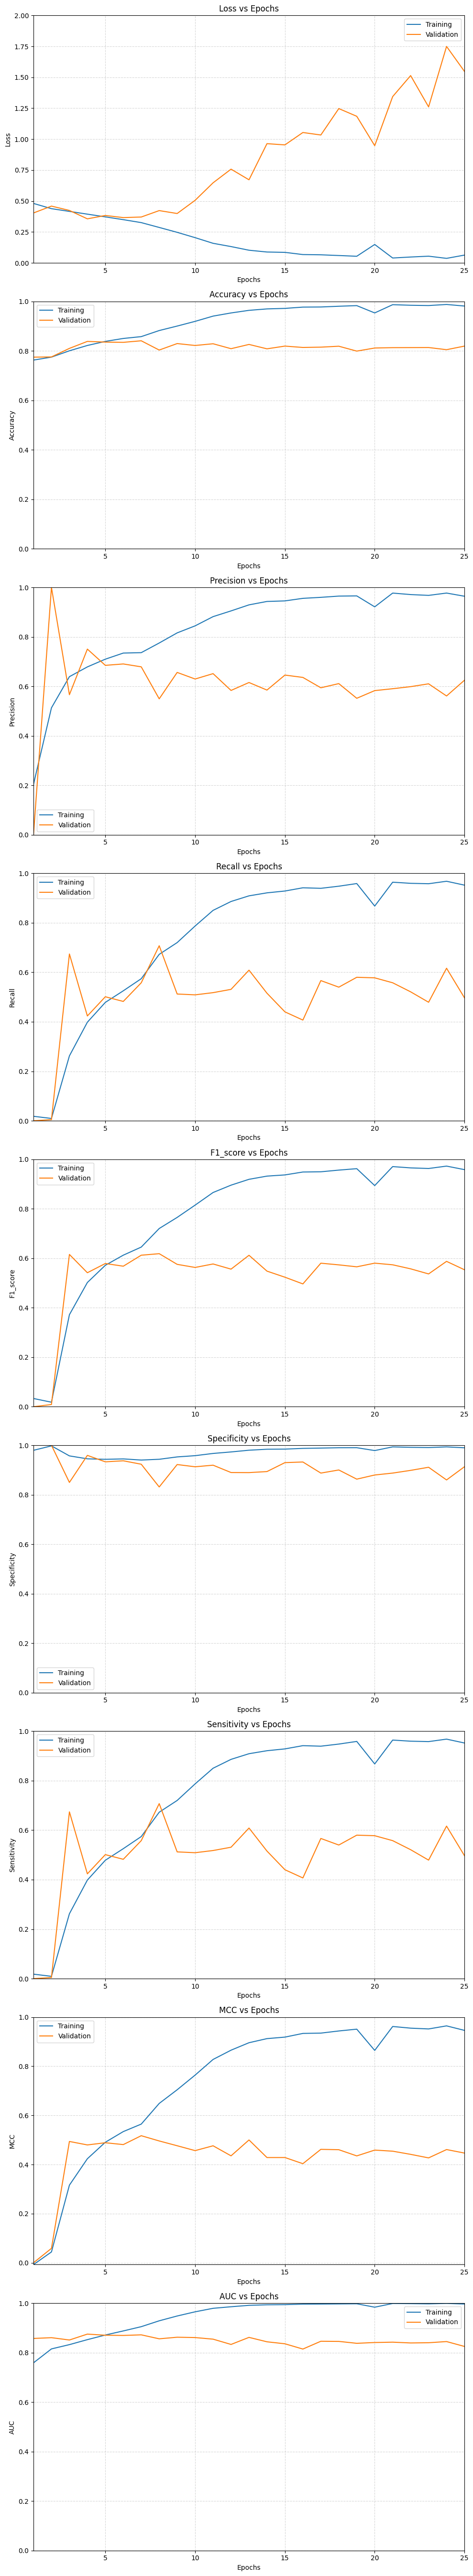

In [ ]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [ ]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing Model"):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)              # (B,1)

        targets = targets.float().unsqueeze(1)
        loss = criterion(outputs, targets)

        total_loss += loss.item()

        all_predictions.extend(
            outputs.detach().cpu().squeeze(1).numpy()
        )
        all_targets.extend(
            targets.detach().cpu().squeeze(1).numpy()
        )

average_loss = total_loss / len(test_loader)

test_metrics = custom_metrics(
    torch.tensor(all_predictions),
    torch.tensor(all_targets),
    average_loss
)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(testing_metrics_line)


Testing Model: 100%|██████████| 501/501 [01:10<00:00,  7.12it/s]

Metrics - loss: 1.4389, accuracy: 0.8241, precision: 0.6324, recall: 0.5244, f1_score: 0.5733, specificity: 0.9113, sensitivity: 0.5244, mcc: 0.4670, auc: 0.8433


In [ ]:
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score

# Convert lists → NumPy
true_labels = np.array(all_targets).astype(int)
logits = np.array(all_predictions)

# Sigmoid → probabilities → binary predictions
probs = 1 / (1 + np.exp(-logits))     # sigmoid
predicted_labels = (probs > 0.5).astype(int)

# Classification report
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=["Negative", "Positive"],
    digits=4,
    zero_division=0
)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(
    f"There were {num_errors} errors in {len(predicted_labels)} tests "
    f"for an accuracy of {accuracy * 100:.2f}%"
)


              precision    recall  f1-score   support

    Negative     0.8682    0.9113    0.8892      3101
    Positive     0.6324    0.5244    0.5733       902

    accuracy                         0.8241      4003
   macro avg     0.7503    0.7179    0.7313      4003
weighted avg     0.8151    0.8241    0.8181      4003

There were 704 errors in 4003 tests for an accuracy of 82.41%


/tmp/ipykernel_55/416845652.py:10: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-logits))     # sigmoid


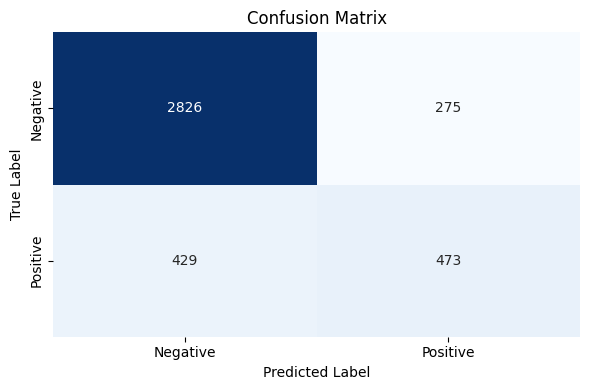

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


NameError: name 'all_logits' is not defined

NameError: name 'classes' is not defined

<Figure size 600x400 with 0 Axes>